In [1]:
import sys
from os import path
import os
import copy
import json
import math
sys.path.insert(0, '../')
os.chdir('../')

from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import seaborn as sns
from descartes import PolygonPatch
from polylabel import polylabel
from shapely import geometry
from IPython.display import HTML
from matplotlib import animation, rc

import polylidar
from util.osm import OSM
from util.lidar import Lidar
from util import create_poly, scale_points


In [11]:
rc('animation', html='html5')
colormap = plt.get_cmap("viridis")
COLOR_PALETTE = sns.color_palette()
def rotate_func(i, n_frames, start=-90):
    # rotate the axes and update
    angle = i / n_frames * 360
    angle_new = angle + start
    ax.view_init(30, angle_new)
    return fig,

def zoom_func(i):
    x_lim = ax.set_xlim(-i,i)

    y_lim = ax.set_ylim(-i, i)

    z_lim = ax.set_zlim(-i, i)

    return plot

In [3]:
with open(path.join('data', 'example.json')) as f:
    example = json.load(f)

# OSM data connection
osm = OSM(bbox=example['bbox'], **example['osm'])
# LIDAR data file connection
lidar = Lidar(proj_osm=osm.proj, **example['lidar'])
# Extract the flat building from OSM
flat_buildings = [building for building in osm.tables['osm_buildings']
                  if building['roof_shape'] == 'flat' and building['area'] > 25]

building = flat_buildings[5]
lidar_building, poly = lidar.get_lidar_building(building, crop=True)
plane_patches, tri, global_indices = polylidar.extract_planes(lidar_building)
geometries = polylidar.plane_meshes_to_polygons(tri, plane_patches)

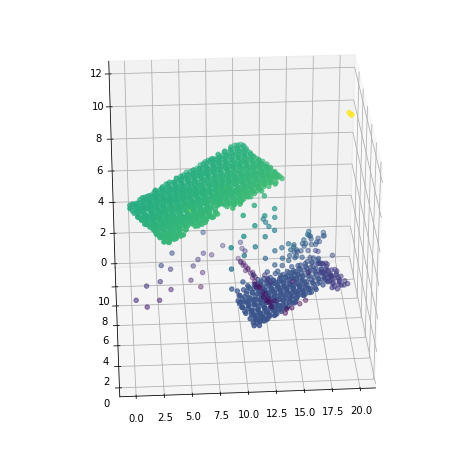

In [29]:
colormap = plt.get_cmap("viridis")
vmax = max(lidar_building[:, 2].ptp(), 10)
norm = colors.Normalize(vmin=0, vmax=vmax)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                       subplot_kw=dict(projection='3d'))
p = ax.scatter(*scale_points(lidar_building),c=colormap(norm(scale_points(lidar_building)[2])))
ax.set_zlim(0, vmax)
ax.view_init(elev=30., azim=-90)
anim = animation.FuncAnimation(fig, rotate_func, frames=100, interval=100, fargs=(100,), blit=True)
anim

In [6]:
vmax = max(lidar_building[:, 2].ptp(), 10)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                       subplot_kw=dict(projection='3d'))
ax.plot_trisurf(*scale_points(lidar_building[:, 0:3]),
                             triangles=tri.simplices[:, :3], cmap=colormap)

ax.set_zlim(0, vmax)
ax.view_init(elev=30., azim=-90)
anim = animation.FuncAnimation(fig, rotate_func, frames=100, interval=100, fargs=(100,), blit=True)
anim

In [8]:
vmax = max(lidar_building[:, 2].ptp(), 10)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                       subplot_kw=dict(projection='3d'))
ax.plot_trisurf(*scale_points(lidar_building[:, 0:3]),
                             triangles=tri.simplices[global_indices, :3], cmap=colormap)

ax.set_zlim(0, vmax)
ax.view_init(elev=55., azim=-90)

In [93]:
vmax = max(lidar_building[:, 2].ptp(), 10)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                       subplot_kw=dict(projection='3d'))
planes = []

ax.plot_trisurf(*scale_points(lidar_building[:, 0:3]),
                             triangles=tri.simplices[global_indices, :3], color=COLOR_PALETTE[0] + (0.1, ), edgecolor='k', linewidth=0.05)

for i, patch_set in enumerate(plane_patches):
    patch = tri.simplices[patch_set]
    plane = ax.plot_trisurf(*scale_points(lidar_building[:, 0:3]),
                     triangles=patch[:, :3], color=COLOR_PALETTE[0] + (0.01, ), edgecolor='none', linewidth=0.05)
    planes.append(plane)

patch1 = [ COLOR_PALETTE[0] + (0.2, ) for i in range(0, plane_patches[0].shape[0])]
patch2 = [ COLOR_PALETTE[0] + (0.2, ) for i in range(0, plane_patches[1].shape[0])]
color_patches = [patch1, patch2]
tris_expanded_per_frame = 32
num_frames = math.ceil((len(patch1) + len(patch2)) / tris_expanded_per_frame)

def color_traingle_func(frame):
    if frame < math.ceil((len(patch1) / tris_expanded_per_frame)):
        plane_mesh, color_patch, frame_, color = planes[0],  color_patches[0], frame, COLOR_PALETTE[0]
    else:
        plane_mesh, color_patch, frame_, color = planes[1],  color_patches[1],  max(0, int(frame - (len(patch1) / tris_expanded_per_frame))), COLOR_PALETTE[1]
    
    for i in range(frame_ * tris_expanded_per_frame, frame_ * tris_expanded_per_frame + tris_expanded_per_frame):
        try:
            color_patch[i] = color
        except:
            pass

    plane_mesh.set_facecolors(color_patch)
    return fig,

anim = animation.FuncAnimation(fig, color_traingle_func, frames=num_frames, interval=100, blit=True)
anim
# anim

In [135]:
def plot_geometries(ax, geometries):
    for i, geom in enumerate(geometries):
        patch = PolygonPatch(
            geom, color=COLOR_PALETTE[i], zorder=1)
        ax.add_patch(patch)

    ax.axis('scaled')
def plot_boxes(i, ax, boxes, num_frames):
    if i < num_frames - 1:
        cell = boxes[i]
        x = cell.x - cell.h; y = cell.y - cell.h;
        patch = mpatches.Rectangle((x, y), 2* cell.h, 2 * cell.h, fill=False, color='crimson')
        ax.add_patch(patch)
    else:
        circle = mpatches.Circle(center1, radius1, ec="black", fill=False, zorder=10)
        marker = mpatches.Circle(center1, .1, ec="black", color='black', fill=True, zorder=11)
        ax.add_patch(circle)
        ax.add_patch(marker)        
    return fig, 

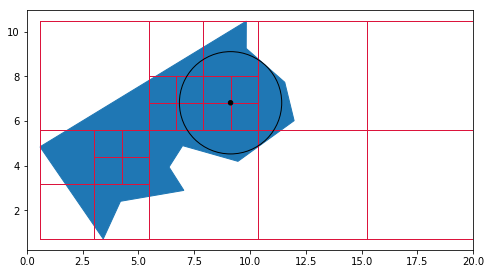

In [136]:
from polylabelgraph.polylabel import polylabel
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

plot_geometries(ax, geometries[:1])
ax.set_xlim(0, 20.0)

coords = polylidar.get_poly_coords(geometries[0])
center1, radius1, boxes1 = polylabel(coords, precision=.5)
# center2, radius2, boxes2 = polylabel(coords, precision=.5)

num_frames = len(boxes1) + 1


anim = animation.FuncAnimation(fig, plot_boxes, frames=num_frames, interval=200, fargs=(ax, boxes1, num_frames), blit=True)
anim

In [163]:
import numpy as np
from shapely.ops import cascaded_union
from shapely.prepared import prep
from shapely.geometry import asPolygon
def mesh_to_polygons_graph(tri, patch, min_area=16):
    """Converts a triangular mesh to a 2D polygon(s)
    If polygon has holes they will be widened by .5 meters, may cut the polygon into two!
    Each polygon must have at least a min area.

    Arguments:
        tri {delaunay} -- A Delaunay object of points that has already been triangulated
        patch {ndarray} -- ndarray of indices of triangles

    Keyword Arguments:
        min_area {int} -- Minimum area of a polygon (default: {16})

    Returns:
        shapely -- List of shapely geometries, may be only a size of 0, 1, or more
    """

    shapely_triangles = []
    final_geometries = []
    patch = tri.simplices[patch]

    # TODO: Optimize this by createing the polygon myself and not using cascaded_union
    # Create Shapely Geometries
    for i in range(patch.shape[0]):
        # print(patch.shape)
        # print(patch)
        # print(tri.points.shape, patch[i,:].shape)
        tri_points = np.array(tri.points[patch[i, :]])
        shapely_tri = np.vstack((tri_points, tri_points[0, :]))
        shapely_triangles.append(asPolygon(shapely_tri))

    building_polygon = cascaded_union(shapely_triangles)
    building_polygon_buffered = building_polygon.buffer(-0.5)
    building_polygon_simple = building_polygon_buffered.simplify(.5)

    return building_polygon, building_polygon_buffered, building_polygon_simple

def plot_geometries(ax, geometries):
    for i, geom in enumerate(geometries):
        patch1 = PolygonPatch(
            geom[0], color=COLOR_PALETTE[i], zorder=1, label='Polygon')
        patch2 = PolygonPatch(
            geom[1], fill=False, zorder=2, linestyle='--', label='Negative buffer')
        patch3 = PolygonPatch(
            geom[2], color='k', fill=False, zorder=3, label='Simplified')
    
        ax.add_patch(patch1)
        ax.add_patch(patch2)
        ax.add_patch(patch3)
    ax.axis('scaled')
    return [patch1, patch2, patch3]



In [168]:
geoms = []
for patch in plane_patches:
    geoms.append(mesh_to_polygons_graph(tri, patch))
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

legend_elements = plot_geometries(ax, geoms)
ax.legend(handles=legend_elements, loc='best')

    


In [166]:
legend_elements